## Nature's Cost Function: Simulating Physics by Minimizing the Action
Tim Strang, Isabella Caruso, and Sam Greydanus | 2023 | MIT License

In physics, there is a scalar function called the action which behaves like a cost function. When minimized, it yields the "path of least action" which represents the path a physical system will take through space and time. This function is crucial in theoretical physics and is usually minimized analytically to obtain equations of motion for various problems. In this notebook, we propose a different approach: instead of minimizing the action analytically, we discretize it and then minimize it directly with gradient descent.

In order to put this view in perspective let's begin by reviewing the standard approaches to solving physics problems.

### Standard approaches

**The analytic approach.** Here you use algebra, calculus, and other mathematical tools to find a closed-form equation of motion for the system. It gives the state of the system as a function of time. For an object in free fall, the equation of motion would be

$$y(t)=\frac{1}{2}gt^2+v_0t+y_0.$$

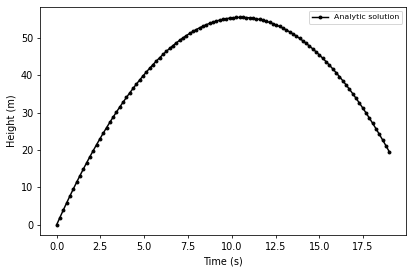

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def falling_object_analytic(x0, x1, dt, g=1, steps=100):
    v0 = (x1 - x0) / dt
    t = np.linspace(0, steps, steps+1) * dt
    x = .5*-g*t**2 + v0*t + x0  # the equation of motion
    return t, x

x0, x1 = [0, 2]
dt = 0.19
t_ana, x_ana = falling_object_analytic(x0, x1, dt)

plt.figure(dpi=70)
plt.plot(t_ana, x_ana, 'k.-', label='Analytic solution')
plt.xlabel('Time (s)') ; plt.ylabel('Height (m)') ; plt.legend(fontsize=8)
plt.tight_layout() ; plt.show()

**The numerical approach.** Not all physics problems have an analytic solution. Some, like the double pendulum or the three-body problem, are deterministic but chaotic. In other words, their dynamics are predictable but we can't know their state at some time in the future without simulating all the intervening states. These we can solve by numerical integration

$$\frac{\partial y}{\partial t} = v(t) \quad \textrm{and} \quad \frac{\partial v}{\partial t} = a(t)$$

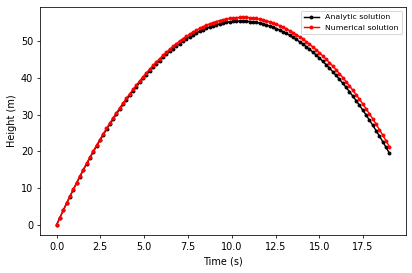

In [50]:
def falling_object_numerical(x0, x1, dt, g=1, steps=100):
    xs = [x0, x1]
    ts = [0, dt]
    v = (x1 - x0) / dt
    x = xs[-1]
    for i in range(steps-1):
        v += -g*dt
        x += v*dt
        xs.append(x)
        ts.append(ts[-1]+dt)
    return np.asarray(ts), np.asarray(xs)

t_num, x_num = falling_object_numerical(x0, x1, dt)

plt.figure(dpi=70)
plt.plot(t_ana, x_ana, 'k.-', label='Analytic solution')
plt.plot(t_num, x_num, 'r.-', label='Numerical solution')
plt.xlabel('Time (s)') ; plt.ylabel('Height (m)') ; plt.legend(fontsize=8)
plt.tight_layout() ; plt.show()

### Dynamics problems as optimization problems

**The Lagrangian method.** The approaches we just covered make intuitive sense. That's why we teach them in introductory physics classes. But there is an entirely different way of looking at dynamics called the Lagrangian method. The Lagrangian method does a better job of describing reality because it can produce equations of motion for _any_ physical system. Lagrangians figure prominently in all four branches of physics: classical mechanics, electricity and magnetism, thermodynamics, and quantum mechanics. Without the Lagrangian method, physicists would have a hard time unifying these disparate fields. But with the [Standard Model Lagrangian](https://www.symmetrymagazine.org/article/the-deconstructed-standard-model-equation) they can do precisely that.

Many of the details of the Lagrangian method are beyond the scope of this work. However, this half-page from David Morin's _Introduction to Classical Mechanics_ does a good job of setting the scene:

![Morin](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/morin_ch6.png)

Earlier in the chapter, Morin asks us to take his word for the fact that L, the Lagrangian, is the difference between the potential and kinetic energy. For a falling particle, L would be \\(\mathcal{L}=T-V=\frac{1}{2}m\dot{y}^2-mgy_0\\). From there, Morin shows that we can use Equation 6.15 to obtain an equation of motion for the system.

**What if I don't like infinities?** In the screenshot above, Morin mentions as an aside, _"If you don’t like infinities, you can imagine breaking up the time interval into, say, a million pieces, and then replacing the integral by a discrete sum."_ The goal of this sentence was to make the idea of a functional more intuitive -- not to provide practical advice for computing the action. But what if we took this sentence literally? What if we used a computer to estimate S (a scalar) and then searched for its stationary values using numerical optimization? In doing so, we could obtain the dynamics of the physical system between times t\\(_1\\) and t\\(_2\\). To our knowledge, nobody has tried this. Why not give it a shot?

### A simple implementation

Let's begin with a list of coordinates, `x`, which contains all the position coordinates of the system between t\\(_1\\) and t\\(_2\\). We can write the Lagrangian and the action of the system in terms of these coordinates. 

In [51]:
def V_freebody(xs):
    return xs

def lagrangian_freebody(x, xdot, m=1, g=1):
    T = .5*m*xdot**2
    V = m*g*x
    return T, V
  
def action(x, dt):
    xdot = (x[1:] - x[:-1]) / dt
    xdot = torch.cat([xdot, xdot[-1:]], axis=0)
    T, V = lagrangian_freebody(x, xdot)
    return T.sum()-V.sum()

Now let's look for a point of stationary action. Technically, this could be a minimum, a maximum, or an inflection point. In many cases, the point of stationary action occurs at a minimum in S. That's the case for this particular problem.

In [134]:
65 in np.linspace(0,int(np.sqrt(15000)),15).astype(np.int32)**2

False

In [156]:
import torch
def get_path_between(x, steps=1000, step_size=1e-1, dt=1, num_prints=15, num_stashes=80):
    t = np.linspace(0, len(x)-1, len(x)) * dt
    print_on = np.linspace(0,int(np.sqrt(steps)),num_prints).astype(np.int32)**2 # bookkeeping (long story)
    stash_on = np.linspace(0,int(np.sqrt(steps)),num_stashes).astype(np.int32)**2 # bookkeeping (long story)
    xs = []
    for i in range(steps):
        grad = torch.autograd.grad(action(x, dt), x)
        grad_x = grad[0]
        grad_x[[0,-1]] *= 0  # fix first and last coordinates by zeroing their grads
        x.data -= grad_x * step_size

        if i in print_on:
            print('step={:04d}, S={:.4e}'.format(i, action(x, dt).item()))
        if i in stash_on:
            xs.append(x.clone().data.numpy())
    return t, x, np.stack(xs)

Now let's put it all together. We can initialize our falling particle's path to be any random path through space. In the code below, we choose a path where the particle bounces around x=0 at random until time t=15 seconds, at which point it leaps up to its final state of x=7.5 meters. This path has a large action of S = 54.6 J·s. As we run the optimization, this value decreases smoothly until we converge on a parabolic arc with an action of S = -1292= J·s.

step=0000, S=5.5985e+03
step=0100, S=1.7061e+02
step=0400, S=-4.5866e+02
step=0900, S=-9.9885e+02
step=1600, S=-1.4902e+03
step=2500, S=-1.8875e+03
step=3600, S=-2.1665e+03
step=4900, S=-2.3373e+03
step=6400, S=-2.4288e+03
step=8100, S=-2.4721e+03
step=10000, S=-2.4901e+03
step=12100, S=-2.4968e+03
step=14400, S=-2.4990e+03
step=16900, S=-2.4996e+03
step=19881, S=-2.4998e+03


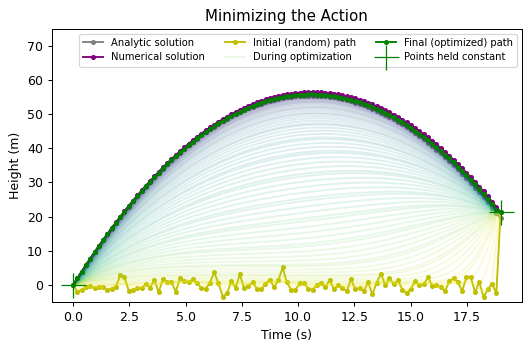

In [161]:
dt = 0.19
x0 = 1.5*torch.randn(len(x_num), requires_grad=True)  # a random path through space
x0[0].data *= 0.0 ; x0[-1].data *= 0.0  # set first and last points to zero
x0[-1].data += x_num[-1]  # set last point to 7.5 (end height of analytic solution)

t, x, xs_ncf = get_path_between(x0.clone(), steps=20000, step_size=1e-2, dt=dt)

plt.figure(dpi=90)
plt.title('Minimizing the Action')
plt.plot(t_ana, x_ana, '.-', color='gray', label='Analytic solution')
plt.plot(t_num, x_num, '.-', color='purple', label='Numerical solution')

plt.plot(t, x0.detach().numpy(), 'y.-', label='Initial (random) path')
for i, xi in enumerate(xs_ncf):
    label = 'During optimization' if i==15 else None
    plt.plot(t, xi, alpha=0.15, color=plt.cm.viridis( 1-i/(len(xs_ncf)-1) ), label=label)
plt.plot(t, x.detach().numpy(), 'g.-', label='Final (optimized) path')
plt.plot(t[[0,-1]], x0.data[[0,-1]], 'g+', markersize=20, label='Points held constant')

plt.ylim(-5, 75)
plt.xlabel('Time (s)') ; plt.ylabel('Height (m)') ; plt.legend(fontsize=8, ncol=3)
plt.tight_layout() ; plt.show()

### Make a video of the simulation process

In [162]:
# !pip install celluloid
from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

In [226]:
def make_video(t, xs, path, interval=60, color='black', mode='ncf', **kwargs): # xs: [time, N, 2]
    fig = plt.gcf() ; fig.set_dpi(200) ; fig.set_size_inches(3, 3)
    camera = Camera(fig)
    for i in range(len(xs) if type(xs) is list else xs.shape[0]):
        if mode == 'ncf':
            for j, xi in enumerate(xs[:i]):
                plt.plot(t, xi, alpha=0.15, color=plt.cm.viridis( 1-j/(len(xs)-1) ), label=label)
            plt.plot(t, xs[0], '.-', color=plt.cm.viridis(0.9))
        plt.plot(t[[0,-1]], xs[-1][[0,-1]], '+', color=color, markersize=16)
        plt.plot(t[:len(xs[i])], xs[i], '.-', color=color)
        plt.xlim(np.min(t)-1, np.max(t)+1) ; plt.ylim(-5, 75)
        plt.xticks([], []); plt.yticks([], []) ; plt.xlabel('Time (s)') ; plt.ylabel('Height (m)')
        camera.snap()
    anim = camera.animate(blit=True, interval=interval, **kwargs)
    anim.save(path) ; plt.close()

In [227]:
len(xs_ncf_), len(xs_ana)

(120, 140)

In [228]:
xs_ncf_ = np.concatenate([xs_ncf[:1]]*20+[xs_ncf]+[xs_ncf[-1:]]*20 )
make_video(t, xs_ncf_, path='./static/ncf.mp4', color='green', interval=80)

mp4 = open('./static/ncf.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [230]:
xs_ana = [x_ana[:1]]*20 + [x_ana[:i+1] for i in range(len(x_ana)-1)]
xs_ana += [xs_ana[-1]]*20
make_video(t, xs_ana, path='./static/ode.mp4', color='purple', mode='ode', interval=80)
mp4 = open('./static/ode.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

### Closing thoughts

In describing how he viewed his life's work, Isaac Newton wrote, "_I do not know what I may appear to the world; but to myself I seem to have been only like a boy playing on the seashore, and diverting myself in now and then finding a smoother pebble or a prettier shell than ordinary, whilst the great ocean of truth lay all undiscovered before me._"

May this work offer for your inspection one more shell from that divine shore.